In [12]:
import pandas as pd
import seaborn as se
import pickle
from collections import Counter
import numpy as np
import os
import pickle
from timeit import timeit
import json
from timeit import default_timer as timer
from pathlib import Path
import shutil
import math
import matplotlib.pyplot as plt
from math import sqrt
from tqdm import tqdm
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt


In [13]:
se.set_style("darkgrid")

PE Utilization    45.04303
dtype: float64

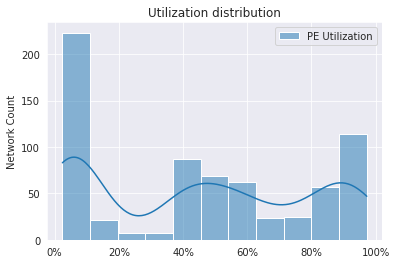

In [14]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)

util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
util = util.rename(columns={"util": "PE Utilization"})
plt = se.histplot(data = util, kde=True)
plt.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.set_ylabel('Network Count')
plt.set_title('Utilization distribution')
util.mean()

/tmp/ipykernel_75334/720191443.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_75334/720191443.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])


Text(0.5, -0.2, 'Contour Plot of Avg. Network PE Utilization & Avg. Network Latency')

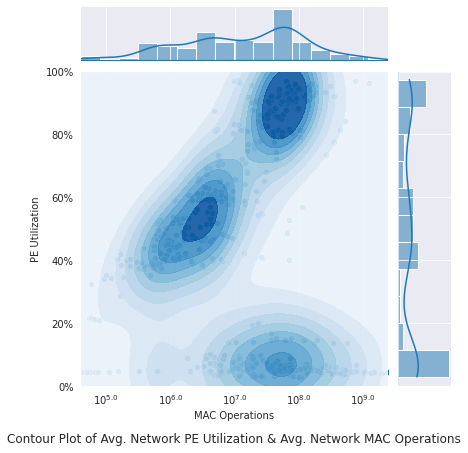

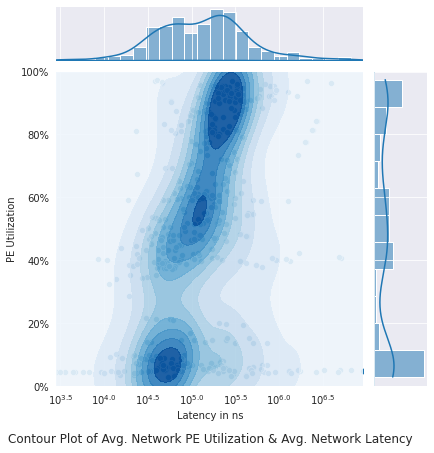

In [35]:
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_2mb.csv', index_col=[0,1],)

util = arch_metrics.groupby(level = 0).mean().loc[:, arch_metrics.columns.isin(['util'])].mul(100)
layer_metrics['macs'] = np.log10(layer_metrics['macs'])
macs_vs_util_df = pd.DataFrame(layer_metrics['macs'].groupby(level=0).mean()).join(util)

plt = se.jointplot(
    data=macs_vs_util_df,
    x="macs",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(0, 100),
    xlim=(
        macs_vs_util_df[["macs"]].min().item(),
        macs_vs_util_df[["macs"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('MAC Operations')
plt.ax_joint.set_title('Contour Plot of Avg. Network PE Utilization & Avg. Network MAC Operations', y = -0.2)



latency = arch_metrics[['latency']].groupby(level=0).mean()
latency = np.log10(latency)
latency_vs_util = latency.join(arch_metrics[['util']].groupby(level=0).mean().mul(100))

plt = se.jointplot(
    data=latency_vs_util,
    x="latency",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.9,
    shade=True,
    thresh=0,
    ylim=(0, 100),
    xlim=(
        latency_vs_util[["latency"]].min().item(),
        latency_vs_util[["latency"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$10^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('Latency in ns')
plt.ax_joint.set_title('Contour Plot of Avg. Network PE Utilization & Avg. Network Latency', y = -0.2)


In [32]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
).join(layer_properties)

slow_layers_with_high_util = arch_metrics[
    (arch_metrics["speedup"] < 1)
    & (arch_metrics["util"] > 0.85)
    & ((arch_metrics["ifmap_mem_size"] < 2**20))
    & ((arch_metrics["ofmap_mem_size"] < 2**20))
]
slow_layers_with_high_util.to_csv('../data/slow_layers_with_high_util.csv')

/tmp/ipykernel_75334/2208550043.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
/tmp/ipykernel_75334/2208550043.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])


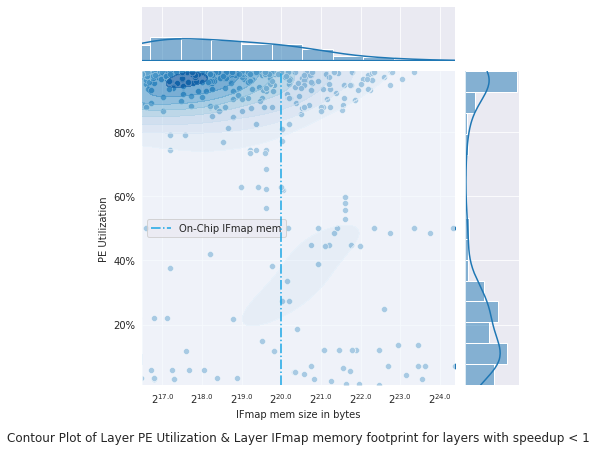

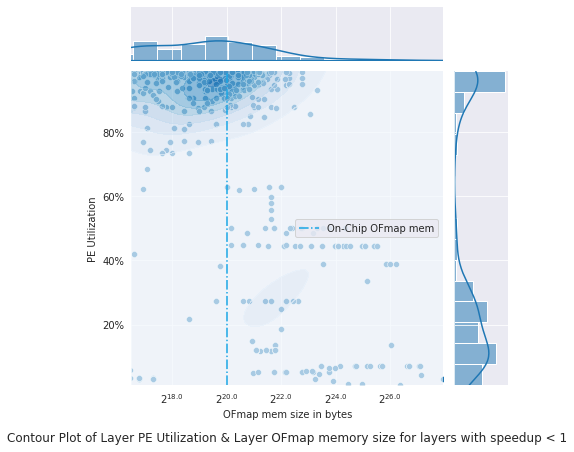

In [33]:
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
layer_properties = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])

util = arch_metrics['util']
speedup = arch_metrics['speedup']
slow_layers_with_low_util = arch_metrics[['util', 'speedup']]
slow_layers_with_low_util = slow_layers_with_low_util[(speedup < 1)]
slow_layer_properties = layer_properties[layer_properties.index.isin(slow_layers_with_low_util.index)].copy()
slow_layer_properties.loc[:, 'total_mem_size'] = pd.DataFrame(np.log2(slow_layer_properties['ifmap_mem_size'] + slow_layer_properties['ofmap_mem_size']))
slow_layer_properties.loc[:, 'ifmap_mem'] = pd.DataFrame(np.log2(slow_layer_properties['ifmap_mem_size']))
slow_layer_properties.loc[:, 'ofmap_mem'] = pd.DataFrame(np.log2(slow_layer_properties['ofmap_mem_size']))
slow_layer_properties.loc[:, 'util'] = slow_layers_with_low_util['util'].mul(100)
plt = se.jointplot(
    data=slow_layer_properties,
    x="ifmap_mem",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.65,
    shade=True,
    thresh=0,
    ylim=(
        slow_layer_properties[["util"]].min().item(),
        slow_layer_properties[["util"]].max().item(),
    ),
    xlim=(
        16.5,
        slow_layer_properties[["ifmap_mem"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=1, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('IFmap mem size in bytes')
plt.ax_joint.set_title('Contour Plot of Layer PE Utilization & Layer IFmap memory footprint for layers with speedup < 1', y = -0.2)
plt.ax_joint.axvline(x = 20, color='#18A5E5', alpha=1, linestyle='-.', zorder=10, label='On-Chip IFmap mem')
plt.ax_joint.legend()

plt = se.jointplot(
    data=slow_layer_properties,
    x="ofmap_mem",
    y="util",
    kind="kde",
    cmap="Blues",
    zorder=5,
    levels=10,
    alpha=0.65,
    shade=True,
    thresh=0,
    ylim=(
        slow_layer_properties[["util"]].min().item(),
        slow_layer_properties[["util"]].max().item(),
    ),
    xlim=(
        16.5,
        slow_layer_properties[["ofmap_mem"]].max().item(),
    ),
)
plt.plot_joint(se.scatterplot)
plt.plot_marginals(se.histplot, zorder=0, kde=True)
plt.ax_marg_y.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ax_marg_x.set_xticklabels([r'$2^{'+str(i)+'}$' for i in plt.ax_marg_x.get_xticks()])
plt.ax_joint.set_ylabel('PE Utilization')
plt.ax_joint.set_xlabel('OFmap mem size in bytes')
plt.ax_joint.set_title('Contour Plot of Layer PE Utilization & Layer OFmap memory size for layers with speedup < 1', y = -0.2)
plt.ax_joint.axvline(x = 20, color='#18A5E5', alpha=1, linestyle='-.', zorder=10, label='On-Chip OFmap mem')
plt.ax_joint.legend()


Text(0.5, -0.3, 'Reason for layers experiencing Speedup < 1 over CPU Baseline')

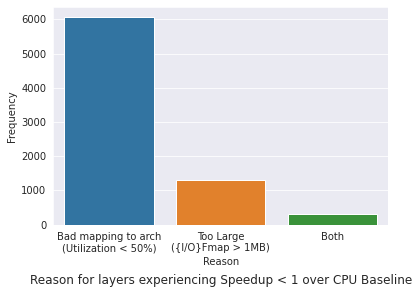

In [34]:
arch_metrics = pd.read_csv(
    "../data/arch_metrics_iofmap_1mb.csv",
    index_col=[0, 1],
)
layer_metrics = pd.read_csv(
    "../data/layer_metrics.csv",
    index_col=[0, 1],
)
arch_metrics = arch_metrics[arch_metrics["speedup"] < 1]
layer_metrics = layer_metrics[layer_metrics.index.isin(arch_metrics.index)]
slow_layers = arch_metrics.join(layer_metrics)
slow_layers["ifmap_huge"] = slow_layers["ifmap_mem_size"] > 2**20
slow_layers["ofmap_huge"] = slow_layers["ofmap_mem_size"] > 2**20
slow_layers["layer_huge"] = (slow_layers["ifmap_mem_size"] > 2**20) & (slow_layers["ofmap_mem_size"] > 2**20)
slow_layers["low_util"] = slow_layers["util"] < 0.5
slow_layers["high_util"] = slow_layers["util"] > 0.95

not_enough_pes = len(slow_layers[slow_layers["util"] > 0.85])
bad_mapping = len(slow_layers[slow_layers["util"] < 0.5])
too_large = len(
    slow_layers[
        (slow_layers["ifmap_huge"] == True) | (slow_layers["ofmap_huge"] == True)
    ]
)
both = len(
    slow_layers[
        ((slow_layers["ifmap_huge"] == True) | (slow_layers["ofmap_huge"] == True))
        & (slow_layers["util"] < 0.5)
    ]
)

counts = pd.DataFrame(
    {
        "Reason": [
            "Bad mapping to arch\n(Utilization < 50%)",
            "Too Large\n({I/O}Fmap > 1MB)",
            "Both",
        ],
        "Frequency": [bad_mapping, too_large, both],
    }
)
plt = se.barplot(data=counts, x="Reason", y="Frequency")
plt.set_title("Reason for layers experiencing Speedup < 1 over CPU Baseline", y=-0.3)

Text(0.5, -0.3, 'Types of layers with speedup < 1 and small memory footprint')

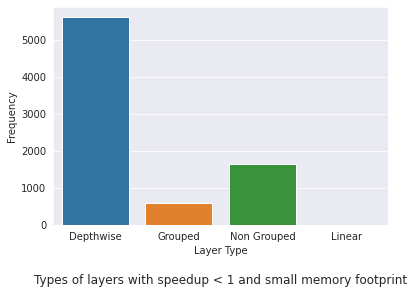

In [28]:
layer_metrics = pd.read_csv('../data/layer_metrics.csv', index_col=[0, 1])
arch_metrics = pd.read_csv('../data/arch_metrics_iofmap_1mb.csv', index_col=[0,1],)
aggregate_metrics = arch_metrics.join(layer_metrics)
layers = aggregate_metrics[['util', 'ifmap_mem_size', 'speedup', 'ofmap_mem_size']]
layers = layers[(layers['ifmap_mem_size'] < 2**20)]
layers = layers[(layers['ofmap_mem_size'] < 2**20)]
layers = layers[(layers['speedup'] < 1)]
# layers = layers[(layers['util'] < 0.5)]

layers = aggregate_metrics[arch_metrics.index.isin(layers.index)]
depthwise_layers = len(layers[layers['groups'] == layers['channels']])
grouped_conv_layers = len(layers[(layers['groups'] != layers['channels']) & (layers['groups'] > 1)])
conv_layers = len(layers[(layers['groups'] == 1)])
non_conv_layers = len(layers[layers['type'] != 'conv'])

counts = pd.DataFrame({
    'Layer Type': ['Depthwise', 'Grouped', 'Non Grouped', 'Linear'],
    'Frequency': [depthwise_layers, grouped_conv_layers, conv_layers, non_conv_layers],
})
plt = se.barplot(data = counts, x='Layer Type', y = 'Frequency')
plt.set_title("Types of layers with speedup < 1 and small memory footprint", y = -0.3)